In [1]:
# Diagnostics
!python -V
from platform import python_version
print('notebook python version: {}'.format(python_version()))

# import modules
import sys
import os
import os.path
import time
import statistics
try:
   import cPickle as pickle
except:
   import pickle
import numpy as np
import pandas as pd
print('pandas version: {}'.format(pd.__version__))
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
import bct
import re
from scipy import signal, integrate, io, stats
from scipy.fft import fft, fftfreq
import math
import matlab
import matlab.engine

# convert number of seconds to hh:mm:ss
def convertSeconds(time): 
    seconds = time % 3600 
    hours = time // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    if seconds < 10:
        seconds = "0" + str(seconds)
    if minutes < 10:
        minutes = "0" + str(minutes)
    if hours < 10:
        hours = "0" + str(hours)
    return ":".join(str(n) for n in [hours,minutes,seconds])

# definitions for filters
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def notch(rem, Q, fs):
    nyq = 0.5 * fs
    w0 = rem / nyq
    b, a = signal.iirnotch(w0, Q, fs)
    return b, a

def notch_filter(data, rem, Q, fs):
    b, a = notch(rem, Q, fs)
    y = signal.lfilter(b, a, data)
    return y

print('All modules imported.')

Python 3.8.5
notebook python version: 3.8.8
pandas version: 1.2.4
All modules imported.


In [17]:
# HUP177
# load in pickle files, unpickle as needed
pickle_dir = '/mnt/local/gdrive/public/USERS/ianzyong/network-states/data/sub-HUP177/eeg'
files = os.listdir(pickle_dir)

# get start times
start_times = [int(re.findall(r'[0-9]+', f)[2]) for f in files]
sorted_times = sorted(start_times)
formatted_time_in_order = [convertSeconds(int(time/1000000)-1) for time in sorted_times]

# sort files by start time
sorted_files = [x for _,x in sorted(zip(start_times,files))]

# load in connectivity matrices 
pickle_data = [pd.read_pickle("{}/{}".format(pickle_dir,f)) for f in sorted_files]

print("Pickle files loaded and read.")

Pickle files loaded and read.


In [18]:
# sampling rate of ieeg.org data
fs = 512

# convert referential montages to bipolar montages

bipolar_data = []

for segment in pickle_data:
    segment_data = segment[0]
    bipolar_channels = []
    for label in segment_data.columns:
        electrode_num = "".join(re.findall(r'[0-9]', label))
        electrode_letters = "".join(re.findall(r'[a-zA-Z]', label))
        num_digits = len(electrode_num)
        electrode_int = int(electrode_num)
        pair_int = electrode_int + 1
        pair_num = str(pair_int)
        while len(pair_num) < len(electrode_num):
            pair_num = "0" + pair_num
        pair_label = electrode_letters + pair_num
        if pair_label in segment_data.columns and electrode_letters != "EKG":
            raw_bipolar = segment_data[label]-segment_data[pair_label];
            # apply filters to raw bipolar montage data
            # bandpass from 0.5 to 80 Hz
            filtered_bipolar = butter_bandpass_filter(raw_bipolar, 0.5, 80, fs, order=6)
            # notch filter at 60 Hz
            filtered_bipolar = notch_filter(filtered_bipolar, 60, 0.99, fs)
            # downsample signal to 200 Hz
            filtered_bipolar = signal.resample(filtered_bipolar, num=30*200)
            bipolar_channels.append(filtered_bipolar)
    bipolar_data.append(bipolar_channels)

In [19]:
# load in MATLAB predictor
eng = matlab.engine.start_matlab()
#model = io.loadmat("tc.mat")
struct = eng.load("/gdrive/public/USERS/ianzyong/network-states/notebooks/tc.mat")
eng.workspace["predictFcn"] = struct['trainedClassifier']['predictFcn']

segment_predictions = []

# obtain data to make predictions
# for each segment
for segment in bipolar_data:
    channel_predictions = []
    # for each channel
    for channel in segment:
        # arrays to store band power
        dp = []
        tp = []
        ap = []
        bp = []
        gp = []
        # for each 6-second-long subsegment
        for sub_start in range(0,30*200,6*200):
            sub_segment = channel[sub_start:sub_start+(6*200)]
            # get spectral density
            [f, spec_dens] = signal.welch(sub_segment,fs=200,nperseg=400,noverlap=200,nfft=400)
            # normalize spectral density
            int_res = integrate.cumtrapz(spec_dens, f)
            total_area = int_res[-1]
            spec_dens = spec_dens/total_area
            
            temp_spec = np.array(spec_dens)
            temp_f = np.array(f)
            # get band power
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=0.5,temp_f<4)],temp_f[np.bitwise_and(temp_f>=0.5,temp_f<4)])
            dp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=4,temp_f<8)],temp_f[np.bitwise_and(temp_f>=4,temp_f<8)])
            tp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=8,temp_f<13)],temp_f[np.bitwise_and(temp_f>=8,temp_f<13)])
            ap.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=13,temp_f<30)],temp_f[np.bitwise_and(temp_f>=13,temp_f<30)])
            bp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=30,temp_f<80)],temp_f[np.bitwise_and(temp_f>=30,temp_f<80)])
            gp.append(int_res[-1])
            
        band_data = [statistics.mean(dp).item(), statistics.mean(tp).item(), statistics.mean(ap).item(), statistics.mean(bp).item(), statistics.mean(gp).item(), statistics.variance(dp).item(), statistics.variance(tp).item(), statistics.variance(ap).item(), statistics.variance(bp).item(), statistics.variance(gp).item(), (max(dp)-min(dp)).item(), (max(tp)-min(tp)).item(), (max(ap)-min(ap)).item(), (max(bp)-min(bp)).item(), (max(gp)-min(gp)).item()]
        if any(math.isnan(x) for x in band_data):
            channel_predictions.append("NaN")
        else:
            eng.workspace["band_data"] = band_data
            eng.workspace["band_data"] = eng.eval("cell2table(band_data)")
            eng.workspace["band_data"] = eng.eval("renamevars(band_data,[\"band_data1\",\"band_data2\",\"band_data3\",\"band_data4\",\"band_data5\",\"band_data6\",\"band_data7\",\"band_data8\",\"band_data9\",\"band_data10\",\"band_data11\",\"band_data12\",\"band_data13\",\"band_data14\",\"band_data15\"],[\"MeanDeltaBandPower\",\"MeanThetaBandPower\",\"MeanAlphaBandPower\",\"MeanBetaBandPower\",\"MeanGammaBandPower\",\"DeltaBandPowerVariance\",\"ThetaBandPowerVariance\",\"AlphaBandPowerVariance\",\"BetaBandPowerVariance\",\"GammaBandPowerVariance\",\"DeltaBandPowerRange\",\"ThetaBandPowerRange\",\"AlphaBandPowerRange\",\"BetaBandPowerRange\",\"GammaBandPowerRange\"])")
            channel_predictions.append(eng.eval("string(predictFcn(band_data))"))
    segment_predictions.append(stats.mode(channel_predictions))
    
prediction_text = [x[0][0] for x in segment_predictions]
prediction_text = [float(x.replace("W","1").replace("N2","0").replace("N3","-1")) for x in prediction_text]

Matrix already in directory.


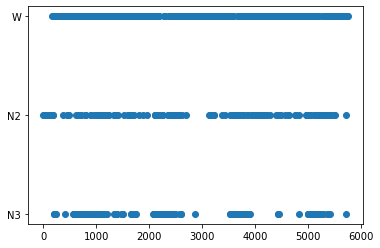

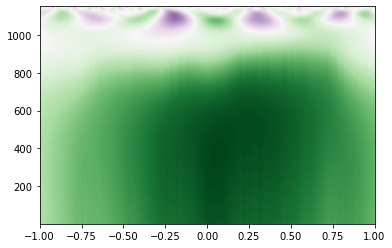

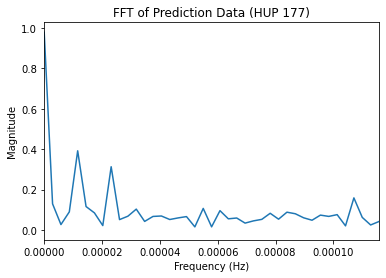

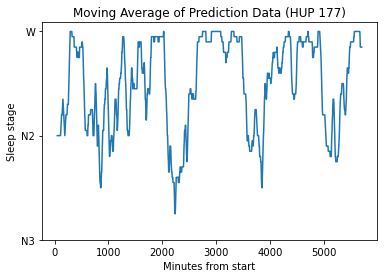

In [3]:
# save results to file if it does not exist
# otherwise, load results
if not os.path.isfile("HUP177_predictions.npy"):
    # save results to file
    np.save("HUP177_predictions.npy",prediction_text)
    prediction_text = np.load("HUP177_predictions.npy",allow_pickle=True)
    
else:
    print("Matrix already in directory.")
    prediction_text = np.load("HUP177_predictions.npy",allow_pickle=True)
    
# plot segment predictions
t = range(0,4*24*60,5)
plt.scatter(t,prediction_text)
plt.yticks([-1, 0, 1],["N3","N2","W"])
plt.show()

# replace NaN values with preceding prediction value
for k in range(0,len(prediction_text)):
    if math.isnan(prediction_text[k]):
        prediction_text[k] = prediction_text[k-1]

# morlet wavelet transform
widths = np.arange(1,1152)
cwtmatr = signal.cwt(prediction_text, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, max(widths)], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

# fft
N = len(prediction_text)
T = 5*60
yf = fft(prediction_text)
xf = fftfreq(N, T)[:N//2]
plt.title("FFT of Prediction Data (HUP 177)")
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0, 10*(1/86400)])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

# moving average
# calculate a moving average
window_size = 20;
half_window = int(window_size/2)
for k in range(half_window,len(prediction_text)-half_window):
    if k == half_window:
        pred_avg = np.mean(prediction_text[k-half_window:k+half_window]);
    else:
        pred_avg = np.append(pred_avg,np.mean(prediction_text[k-half_window:k+half_window]))
        
plt.title("Moving Average of Prediction Data (HUP 177)")
plt.plot(5*np.arange(half_window,len(prediction_text)-half_window),pred_avg)
plt.yticks([-1, 0, 1],["N3","N2","W"])
plt.xlabel("Minutes from start")
plt.ylabel("Sleep stage")
plt.show()

In [21]:
# HUP166
# load in pickle files, unpickle as needed
pickle_dir = '/mnt/local/gdrive/public/USERS/ianzyong/network-states/data/sub-HUP166/eeg'
files = os.listdir(pickle_dir)

# get start times
start_times = [int(re.findall(r'[0-9]+', f)[2]) for f in files]
sorted_times = sorted(start_times)
formatted_time_in_order = [convertSeconds(int(time/1000000)-1) for time in sorted_times]

# sort files by start time
sorted_files = [x for _,x in sorted(zip(start_times,files))]

# load in connectivity matrices 
pickle_data = [pd.read_pickle("{}/{}".format(pickle_dir,f)) for f in sorted_files]

print("Pickle files loaded and read.")

Pickle files loaded and read.


In [22]:
# sampling rate of ieeg.org data
fs = 512

# convert referential montages to bipolar montages

bipolar_data = []
bipolar_labels = []
bipolar_label_pairs = []

for segment in pickle_data:
    segment_data = segment[0]
    bipolar_channels = []
    for label in segment_data.columns:
        electrode_num = "".join(re.findall(r'[0-9]', label))
        electrode_letters = "".join(re.findall(r'[a-zA-Z]', label))
        num_digits = len(electrode_num)
        electrode_int = int(electrode_num)
        pair_int = electrode_int + 1
        pair_num = str(pair_int)
        while len(pair_num) < len(electrode_num):
            pair_num = "0" + pair_num
        pair_label = electrode_letters + pair_num
        if pair_label in segment_data.columns and electrode_letters != "EKG":
            raw_bipolar = segment_data[label]-segment_data[pair_label];
            # apply filters to raw bipolar montage data
            # bandpass from 0.5 to 80 Hz
            filtered_bipolar = butter_bandpass_filter(raw_bipolar, 0.5, 80, fs, order=6)
            # notch filter at 60 Hz
            filtered_bipolar = notch_filter(filtered_bipolar, 60, 0.99, fs)
            # downsample signal to 200 Hz
            filtered_bipolar = signal.resample(filtered_bipolar, num=30*200)
            bipolar_channels.append(filtered_bipolar)
            bipolar_labels.append(label)
            bipolar_label_pairs.append(pair_label)
    bipolar_data.append(bipolar_channels)

In [23]:
# load in MATLAB predictor
eng = matlab.engine.start_matlab()
#model = io.loadmat("tc.mat")
struct = eng.load("/gdrive/public/USERS/ianzyong/network-states/notebooks/tc.mat")
eng.workspace["predictFcn"] = struct['trainedClassifier']['predictFcn']

segment_predictions = []

# obtain data to make predictions
# for each segment
for segment in bipolar_data:
    channel_predictions = []
    # for each channel
    for channel in segment:
        # arrays to store band power
        dp = []
        tp = []
        ap = []
        bp = []
        gp = []
        # for each 6-second-long subsegment
        for sub_start in range(0,30*200,6*200):
            sub_segment = channel[sub_start:sub_start+(6*200)]
            # get spectral density
            [f, spec_dens] = signal.welch(sub_segment,fs=200,nperseg=400,noverlap=200,nfft=400)
            # normalize spectral density
            int_res = integrate.cumtrapz(spec_dens, f)
            total_area = int_res[-1]
            spec_dens = spec_dens/total_area
            
            temp_spec = np.array(spec_dens)
            temp_f = np.array(f)
            # get band power
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=0.5,temp_f<4)],temp_f[np.bitwise_and(temp_f>=0.5,temp_f<4)])
            dp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=4,temp_f<8)],temp_f[np.bitwise_and(temp_f>=4,temp_f<8)])
            tp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=8,temp_f<13)],temp_f[np.bitwise_and(temp_f>=8,temp_f<13)])
            ap.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=13,temp_f<30)],temp_f[np.bitwise_and(temp_f>=13,temp_f<30)])
            bp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=30,temp_f<80)],temp_f[np.bitwise_and(temp_f>=30,temp_f<80)])
            gp.append(int_res[-1])
            
        band_data = [statistics.mean(dp).item(), statistics.mean(tp).item(), statistics.mean(ap).item(), statistics.mean(bp).item(), statistics.mean(gp).item(), statistics.variance(dp).item(), statistics.variance(tp).item(), statistics.variance(ap).item(), statistics.variance(bp).item(), statistics.variance(gp).item(), (max(dp)-min(dp)).item(), (max(tp)-min(tp)).item(), (max(ap)-min(ap)).item(), (max(bp)-min(bp)).item(), (max(gp)-min(gp)).item()]
        if any(math.isnan(x) for x in band_data):
            channel_predictions.append("NaN")
        else:
            eng.workspace["band_data"] = band_data
            eng.workspace["band_data"] = eng.eval("cell2table(band_data)")
            eng.workspace["band_data"] = eng.eval("renamevars(band_data,[\"band_data1\",\"band_data2\",\"band_data3\",\"band_data4\",\"band_data5\",\"band_data6\",\"band_data7\",\"band_data8\",\"band_data9\",\"band_data10\",\"band_data11\",\"band_data12\",\"band_data13\",\"band_data14\",\"band_data15\"],[\"MeanDeltaBandPower\",\"MeanThetaBandPower\",\"MeanAlphaBandPower\",\"MeanBetaBandPower\",\"MeanGammaBandPower\",\"DeltaBandPowerVariance\",\"ThetaBandPowerVariance\",\"AlphaBandPowerVariance\",\"BetaBandPowerVariance\",\"GammaBandPowerVariance\",\"DeltaBandPowerRange\",\"ThetaBandPowerRange\",\"AlphaBandPowerRange\",\"BetaBandPowerRange\",\"GammaBandPowerRange\"])")
            channel_predictions.append(eng.eval("string(predictFcn(band_data))"))
    segment_predictions.append(stats.mode(channel_predictions))
    
prediction_text = [x[0][0] for x in segment_predictions]
prediction_text = [float(x.replace("W","1").replace("N2","0").replace("N3","-1")) for x in prediction_text]

Matrix already in directory.


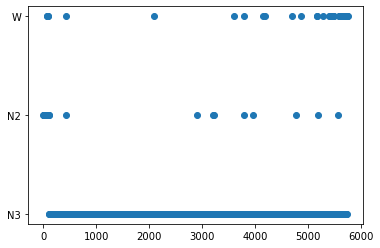

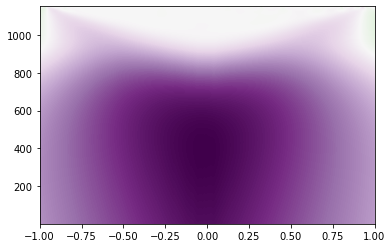

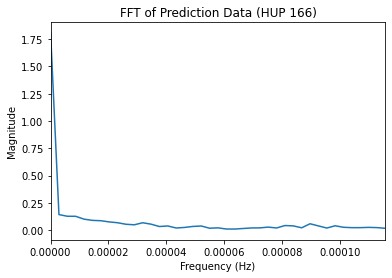

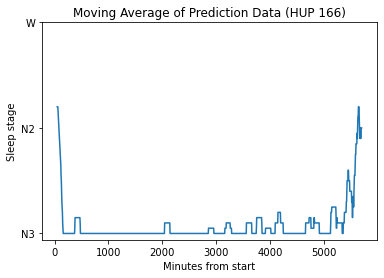

In [5]:
# save results to file if it does not exist
# otherwise, load results
if not os.path.isfile("HUP166_predictions.npy"):
    
    # save results to file
    np.save("HUP166_predictions.npy",prediction_text)
    
else:
    print("Matrix already in directory.")
    prediction_text = np.load("HUP166_predictions.npy",allow_pickle=True)
    
# plot segment predictions
t = range(0,4*24*60,5)
plt.scatter(t,prediction_text)
plt.yticks([-1, 0, 1],["N3","N2","W"])
plt.show()

# replace NaN values with preceding prediction value
for k in range(0,len(prediction_text)):
    if math.isnan(prediction_text[k]):
        prediction_text[k] = prediction_text[k-1]

# morlet wavelet transform
widths = np.arange(1,1152)
cwtmatr = signal.cwt(prediction_text, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, max(widths)], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

# fft
N = len(prediction_text)
T = 5*60
yf = fft(prediction_text)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0, 10*(1/86400)])
plt.title("FFT of Prediction Data (HUP 166)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

# moving average
# calculate a moving average
window_size = 20;
half_window = int(window_size/2)
for k in range(half_window,len(prediction_text)-half_window):
    if k == half_window:
        pred_avg = np.mean(prediction_text[k-half_window:k+half_window]);
    else:
        pred_avg = np.append(pred_avg,np.mean(prediction_text[k-half_window:k+half_window]))
        
plt.plot(5*np.arange(half_window,len(prediction_text)-half_window),pred_avg)
plt.yticks([-1, 0, 1],["N3","N2","W"])
plt.title("Moving Average of Prediction Data (HUP 166)")
plt.xlabel("Minutes from start")
plt.ylabel("Sleep stage")
plt.show()

In [25]:
# HUP173
# load in pickle files, unpickle as needed
pickle_dir = '/mnt/local/gdrive/public/USERS/ianzyong/network-states/data/sub-HUP173/eeg'
files = os.listdir(pickle_dir)

# get start times
start_times = [int(re.findall(r'[0-9]+', f)[2]) for f in files]
sorted_times = sorted(start_times)
formatted_time_in_order = [convertSeconds(int(time/1000000)-1) for time in sorted_times]

# sort files by start time
sorted_files = [x for _,x in sorted(zip(start_times,files))]

# load in connectivity matrices 
pickle_data = [pd.read_pickle("{}/{}".format(pickle_dir,f)) for f in sorted_files]

print("Pickle files loaded and read.")

Pickle files loaded and read.


In [26]:
# sampling rate of ieeg.org data
fs = 512

# convert referential montages to bipolar montages

bipolar_data = []
bipolar_labels2 = []
bipolar_label_pairs2 = []

for segment in pickle_data:
    segment_data = segment[0]
    bipolar_channels = []
    for label in segment_data.columns:
        electrode_num = "".join(re.findall(r'[0-9]', label))
        electrode_letters = "".join(re.findall(r'[a-zA-Z]', label))
        num_digits = len(electrode_num)
        electrode_int = int(electrode_num)
        pair_int = electrode_int + 1
        pair_num = str(pair_int)
        while len(pair_num) < len(electrode_num):
            pair_num = "0" + pair_num
        pair_label = electrode_letters + pair_num
        if pair_label in segment_data.columns and electrode_letters != "EKG":
            raw_bipolar = segment_data[label]-segment_data[pair_label];
            # apply filters to raw bipolar montage data
            # bandpass from 0.5 to 80 Hz
            filtered_bipolar = butter_bandpass_filter(raw_bipolar, 0.5, 80, fs, order=6)
            # notch filter at 60 Hz
            filtered_bipolar = notch_filter(filtered_bipolar, 60, 0.99, fs)
            # downsample signal to 200 Hz
            filtered_bipolar = signal.resample(filtered_bipolar, num=30*200)
            bipolar_channels.append(filtered_bipolar)
            bipolar_labels2.append(label)
            bipolar_label_pairs2.append(pair_label)
    bipolar_data.append(bipolar_channels)

In [27]:
# load in MATLAB predictor
eng = matlab.engine.start_matlab()
#model = io.loadmat("tc.mat")
struct = eng.load("/gdrive/public/USERS/ianzyong/network-states/notebooks/tc.mat")
eng.workspace["predictFcn"] = struct['trainedClassifier']['predictFcn']

segment_predictions = []

# obtain data to make predictions
# for each segment
for segment in bipolar_data:
    channel_predictions = []
    # for each channel
    for channel in segment:
        # arrays to store band power
        dp = []
        tp = []
        ap = []
        bp = []
        gp = []
        # for each 6-second-long subsegment
        for sub_start in range(0,30*200,6*200):
            sub_segment = channel[sub_start:sub_start+(6*200)]
            # get spectral density
            [f, spec_dens] = signal.welch(sub_segment,fs=200,nperseg=400,noverlap=200,nfft=400)
            # normalize spectral density
            int_res = integrate.cumtrapz(spec_dens, f)
            total_area = int_res[-1]
            spec_dens = spec_dens/total_area
            
            temp_spec = np.array(spec_dens)
            temp_f = np.array(f)
            # get band power
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=0.5,temp_f<4)],temp_f[np.bitwise_and(temp_f>=0.5,temp_f<4)])
            dp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=4,temp_f<8)],temp_f[np.bitwise_and(temp_f>=4,temp_f<8)])
            tp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=8,temp_f<13)],temp_f[np.bitwise_and(temp_f>=8,temp_f<13)])
            ap.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=13,temp_f<30)],temp_f[np.bitwise_and(temp_f>=13,temp_f<30)])
            bp.append(int_res[-1])
            int_res = integrate.cumtrapz(temp_spec[np.bitwise_and(temp_f>=30,temp_f<80)],temp_f[np.bitwise_and(temp_f>=30,temp_f<80)])
            gp.append(int_res[-1])
            
        band_data = [statistics.mean(dp).item(), statistics.mean(tp).item(), statistics.mean(ap).item(), statistics.mean(bp).item(), statistics.mean(gp).item(), statistics.variance(dp).item(), statistics.variance(tp).item(), statistics.variance(ap).item(), statistics.variance(bp).item(), statistics.variance(gp).item(), (max(dp)-min(dp)).item(), (max(tp)-min(tp)).item(), (max(ap)-min(ap)).item(), (max(bp)-min(bp)).item(), (max(gp)-min(gp)).item()]
        if any(math.isnan(x) for x in band_data):
            channel_predictions.append("NaN")
        else:
            eng.workspace["band_data"] = band_data
            eng.workspace["band_data"] = eng.eval("cell2table(band_data)")
            eng.workspace["band_data"] = eng.eval("renamevars(band_data,[\"band_data1\",\"band_data2\",\"band_data3\",\"band_data4\",\"band_data5\",\"band_data6\",\"band_data7\",\"band_data8\",\"band_data9\",\"band_data10\",\"band_data11\",\"band_data12\",\"band_data13\",\"band_data14\",\"band_data15\"],[\"MeanDeltaBandPower\",\"MeanThetaBandPower\",\"MeanAlphaBandPower\",\"MeanBetaBandPower\",\"MeanGammaBandPower\",\"DeltaBandPowerVariance\",\"ThetaBandPowerVariance\",\"AlphaBandPowerVariance\",\"BetaBandPowerVariance\",\"GammaBandPowerVariance\",\"DeltaBandPowerRange\",\"ThetaBandPowerRange\",\"AlphaBandPowerRange\",\"BetaBandPowerRange\",\"GammaBandPowerRange\"])")
            channel_predictions.append(eng.eval("string(predictFcn(band_data))"))
    segment_predictions.append(stats.mode(channel_predictions))
    
prediction_text = [x[0][0] for x in segment_predictions]
prediction_text = [float(x.replace("W","1").replace("N2","0").replace("N3","-1")) for x in prediction_text]

Matrix already in directory.


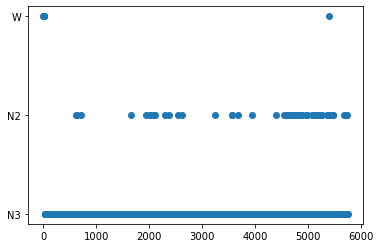

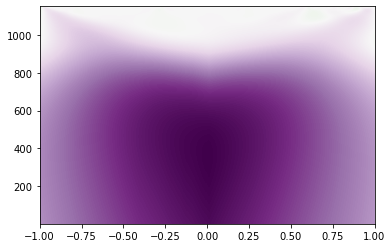

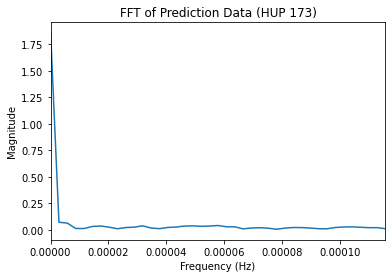

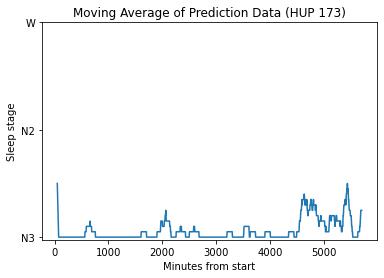

In [4]:
# save results to file if it does not exist
# otherwise, load results
if not os.path.isfile("HUP173_predictions.npy"):
    
    # save results to file
    np.save("HUP173_predictions.npy",prediction_text)
    
else:
    print("Matrix already in directory.")
    prediction_text = np.load("HUP173_predictions.npy",allow_pickle=True)
    
# plot segment predictions
t = range(0,4*24*60,5)
plt.scatter(t,prediction_text)
plt.yticks([-1, 0, 1],["N3","N2","W"])
plt.show()

# replace NaN values with preceding prediction value
for k in range(0,len(prediction_text)):
    if math.isnan(prediction_text[k]):
        prediction_text[k] = prediction_text[k-1]

# morlet wavelet transform
widths = np.arange(1,1152)
cwtmatr = signal.cwt(prediction_text, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, max(widths)], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

# fft
N = len(prediction_text)
T = 5*60
yf = fft(prediction_text)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0, 10*(1/86400)])
plt.title("FFT of Prediction Data (HUP 173)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

# moving average
# calculate a moving average
window_size = 20;
half_window = int(window_size/2)
for k in range(half_window,len(prediction_text)-half_window):
    if k == half_window:
        pred_avg = np.mean(prediction_text[k-half_window:k+half_window]);
    else:
        pred_avg = np.append(pred_avg,np.mean(prediction_text[k-half_window:k+half_window]))
        
plt.plot(5*np.arange(half_window,len(prediction_text)-half_window),pred_avg)
plt.yticks([-1, 0, 1],["N3","N2","W"])
plt.title("Moving Average of Prediction Data (HUP 173)")
plt.xlabel("Minutes from start")
plt.ylabel("Sleep stage")
plt.show()

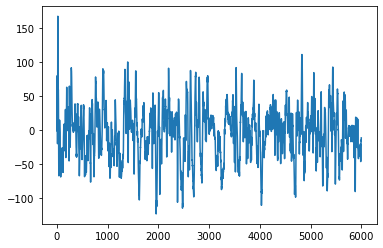

In [29]:
plt.plot(bipolar_data[10][5])